-------------------------------------------------------------------
| function to minimize: (x-1)^2 + y^2                             |
| limitation: x^2 - y <= 0                                        |
-------------------------------------------------------------------
Input starting point (two numbers separated by space)
which satisfies limitation x^2 - y < 0 :
3 15
Input precision:
0.001
Input max number of steps:
10
------------------barrier step----------------------------
[0.3619132600583196, 0.8836562065650283]

------------------barrier step----------------------------
[0.4024740643321966, 0.7423160901884]

------------------barrier step----------------------------
[0.4248887135938449, 0.6767797248261641]

------------------barrier step----------------------------
[0.4398993977666371, 0.6366235688744145]

------------------barrier step----------------------------
[0.4509781453775174, 0.6087011818156765]

------------------barrier step----------------------------
[0.45964389972

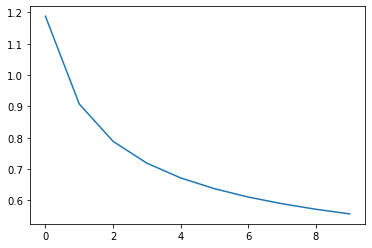

In [2]:
#!/usr/bin/env python
# coding: utf-8

from math import fabs
from math import exp
from math import sqrt
from math import log
import matplotlib.pyplot as plt


class Matrix:
    
    def __init__(self, array):
        self.array = array
        #save the size of array
        if(isinstance(array,list)):
            self.height = len(array)
        else:
            self.height = 1
        if(isinstance(array[0], list)):
            self.width = len(array[0])
        else:
            self.width = 1
    
    def size(self):
        print('height = ', self.height)
        print('width = ', self.width)
        
    #returns float from Matrix in position (i,j)
    def __call__(self, i, j):
        return self.array[i][j]
        
    def __str__(self) -> str:
        s : str = ''
        for i in range(self.height):
            s += '['
            for j in range(self.width):
                s += str(self(i,j))
                if(j != self.width - 1):
                    s += ', '
            s += ']'
            s += '\n'
        return s
    
    def __repr__(self):
        return 'Matrix\n' + self.__str__()
    
    #left multiplication
    def __mul__(self, other) -> 'Matrix':
        #multiply on number
        if(isinstance(other, (int, float))):
            res = []
            for i in range(self.height):
                row = [self(i,j)*other for j in range(self.width)]
                res.append(row)
            return Matrix(res)
        #multiply on Matrix
        elif(isinstance(other, Matrix)):
            if(self.width != other.height):
                raise NotImplementedError('Unsupported sizes of matrices')
            res = []
            #i is the number of row in self matrix
            for i in range(self.height):
                row = []
                #j is the number of column in other matrix
                for j in range(other.width):
                    #multiplication
                    num = 0
                    for k in range(self.width):
                        num += self(i,k) * other(k,j)
                    row.append(num)
                res.append(row)
            return Matrix(res)
        else:
            return NotImplemented
    
    #right multiplication on number
    def __rmul__(self, other) -> 'Matrix':
        if(isinstance(other, (int, float))):
            res = []
            for i in range(self.height):
                row = [self(i,j)*other for j in range(self.width)]
                res.append(row)
            return Matrix(res)
        else:
            return NotImplemented
        
    def __add__(self, other) -> 'Matrix':
        if(isinstance(other, Matrix)):
            res = []
            for i in range(self.height):
                row = [self(i,j) + other(i,j) for j in range(self.width)]
                res.append(row)
            return Matrix(res)
        else:
            NotImplemented
            
    def transpose(self) -> 'Matrix':
        res = [[self(j,i) for j in range(self.height)] for i in range(self.width)]
        return Matrix(res)
    
    #returns minor for element (i,j)
    def get_minor(self, i, j) -> 'Matrix':
        arr = self.array
        return Matrix([row[:j] + row[j+1:] for row in (arr[:i]+arr[i+1:])])
    
    #finds determinant of matrix
    def find_det(self) -> float:
        if(self.width == 1):
            return self(0,0)
        d = 0
        for j in range(self.width):
            d += (-1)**j * self(0,j) * self.get_minor(0,j).find_det()
        return d
    
    #finds A**(-1)
    def invert(self) -> 'Matrix':
        if(self.height != self.width):
            return NotImplemented
        self_det = self.find_det()
        res = []
        for i in range(self.height):
            row = []
            for j in range(self.width):
                minor = self.get_minor(i,j)
                minor_det = minor.find_det()
                row.append(minor_det * (-1)**(i+j))
            res.append(row)
        res = Matrix(res)
        return res.transpose() * (1 / self_det)
    
    #returns new matrix with calculated elements
    #matrix must contain callable elements
    def calculate(self, x, y) -> 'Matrix':
        res = []
        for i in range(self.height):
            row = []
            for j in range(self.width):
                if(callable(self(i,j))):
                    row.append(self(i,j)(x, y))
            res.append(row)
        return Matrix(res)



#creates matrix of subtitution of first derivatives
def sub_diff_matrix(U, V, diff1, diff2) -> Matrix:
    n = U.width
    res = []
    for i in range(1,n+1):
        row = []
        for j in range(1,n+1):
            #fills matrix according to formulas
            if(abs(U(0,j-1) - V(0,j-1)) < 10**(-11)):
                params = tuple(V(0,k-1) for k in range(1,j+1)) + tuple(U(0,k-1) for k in range(j+1,n+1))
                elem = diff2(i-1,j-1)(*params)
            else:
                params1 = tuple(V(0,k-1) for k in range(1,j)) + tuple(U(0,k-1) for k in range(j,n+1))
                params2 = tuple(V(0,k-1) for k in range(1,j+1)) + tuple(U(0,k-1) for k in range(j+1,n+1))
                elem = (diff1(0,i-1)(*params1) - diff1(0,i-1)(*params2)) / (U(0,j-1) - V(0,j-1))
            row.append(elem)
        res.append(row)
    return Matrix(res)



#returns norm of difference
def norm(U1, U2) -> float:
    res = 0
    for i in range(U1.width):
        res += (U1(0,i) - U2(0,i))**2
    return sqrt(res)



#finds min of function by stefenson method
#diff1 is an array of first derivatives
#diff2 is a matrix of second derivatives
def stefenson(U_k, beta, diff1, diff2, epsilon) -> Matrix:
    
    #step
    delta = 1
    
    while True:
        
        #stefenson method formulas
        diff1_k = diff1.calculate(U_k(0,0), U_k(0,1))
        V_k = U_k + (-beta) * diff1_k
        J_ij = sub_diff_matrix(U_k, V_k, diff1, diff2)
        J_invert = J_ij.invert()
        U_next = U_k.transpose() + delta*(-1)*J_invert*diff1_k.transpose()
        U_next = U_next.transpose()
        
        #changes step length
        #next iteration must be in the limitation
        if(U_next(0,1)-U_next(0,0)**2 <= 0):
            delta = delta/2
        else:
            #check norm
            if(norm(U_k, U_next) < epsilon):
                #print('U_next =', U_next)
                return U_next
            else:
                #print('U_next =', U_next)
                #print('------------------stefenson step--------------------------',k)
                #print("delta = ", delta)
                U_k = U_next



def barrier_optimization(U_k, k, f, B, epsilon, max_step) -> (list, float):
    
    #saves function for plot
    f_x = []
    
    beta = 0.01
    while True:
        
        #first and second differential
        diff1 = Matrix([[lambda x,y : 2*(x-1) + 1/k*2*x*(y-x**2)**(-2), lambda x,y : 2*y + 1/k*(-1)*(y-x**2)**(-2)]])
        diff2 = Matrix([[lambda x,y : 2+1/k*(2*(y-x**2)+4*x)*(y-x**2)**(-3), lambda x,y : 1/k*(-4)*x*(y-x**2)**(-3)],
                        [lambda x,y : 1/k*(-4)*x*(y-x**2)**(-3), lambda x,y : 2+1/k*2*(y-x**2)**(-3)]])
        
        #next step
        U_next = stefenson(U_k, beta, diff1, diff2, epsilon)
        f_x.append(f(U_next))
        
        #check norm
        if(norm(U_k, U_next) < epsilon or k >= max_step):
            print('---------------------FINALLY------------------------------')
            print('number of steps: ', k)
            print(U_next)
            return f_x
        else:
            print('------------------barrier step----------------------------')
            #print('number of steps: ', k)
            print(U_next)
            k += 1
            U_k = U_next



#barrier function
def B(U) -> float:
    return 1 / (U(0,1)-U(0,0)**2)

#function to minimize
def f(U) -> float:
    return (U(0,0)-1)**2+U(0,1)**2


#main
print("-------------------------------------------------------------------")
print("| function to minimize: (x-1)^2 + y^2                             |")
print("| limitation: x^2 - y <= 0                                        |")
print("-------------------------------------------------------------------")
while True:
    print("Input starting point (two numbers separated by space)")
    print("which satisfies limitation x^2 - y < 0 :")
    x, y = [float(x) for x in input().split()]
    if(B(Matrix([[x,y]])) > 0):
        break
    else:
        print("Incorrect input")
print("Input precision:")
epsilon = float(input())
print("Input max number of steps:")
max_step = int(input())

f_x = barrier_optimization(Matrix([[x,y]]), 1, f, B, epsilon, max_step)

iteration = [k for k in range(len(f_x))]
plt.plot(iteration, f_x)
plt.show()
